# Car Price prediction

<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам

## Мы сделаем следующее:
* Построим "наивную"/baseline модель, предсказывающую цену по модели и году выпуска (с ней будем сравнивать другие модели)
* Обработаем и отнормируем признаки
* Сделаем первую модель на основе градиентного бустинга с помощью CatBoost
* Сделаем вторую модель на основе нейронных сетей и сравним результаты
* Сделаем multi-input нейронную сеть для анализа табличных данных и текста одновременно
* Добавим в multi-input сеть обработку изображений
* Осуществим проброс признака 
* Осуществим ансамблирование градиентного бустинга и нейронной сети (усреднение их предсказаний)  

In [1]:
!pip install -q pymorphy2
!pip install -q pymorphy2-dicts

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
!pip install -q tensorflow==2.3

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
#аугментации изображений
!pip install albumentations -q

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [4]:
import random
import numpy as np
import pandas as pd
import os
import sys
import PIL
import cv2
import re
import pymorphy2

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

# keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import albumentations

# plt
import matplotlib.pyplot as plt

#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

# Чтобы pandas отображал все столбцы
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 170)

from pprint import pprint
import seaborn as sns

In [5]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0


In [6]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [7]:
# зафиксируем RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [8]:
!pip freeze > requirements.txt

# DATA

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, целевой
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [9]:
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [11]:
train.nunique()

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
dtype: int64

# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



In [12]:
# split данных
data_train, data_test = train_test_split(train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [13]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


# EDA

Проведем анализ данных, чтобы понимать, сможет ли с этими данными работать наш алгоритм.

Посмотрим, как выглядят распределения числовых признаков:

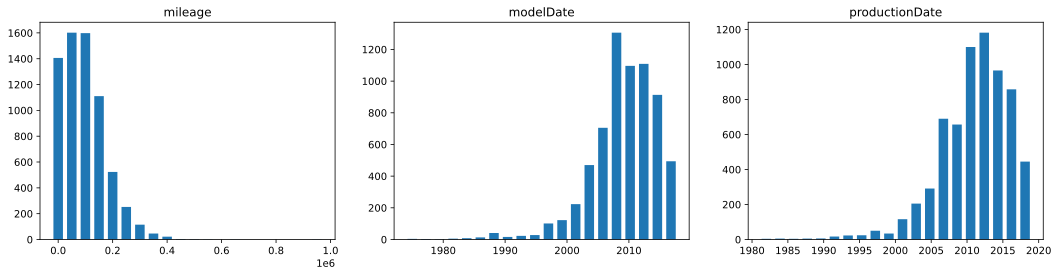

In [14]:
#посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 20)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

visualize_distributions({
    'mileage': train['mileage'].dropna(),
    'modelDate': train['modelDate'].dropna(),
    'productionDate': train['productionDate'].dropna()
})

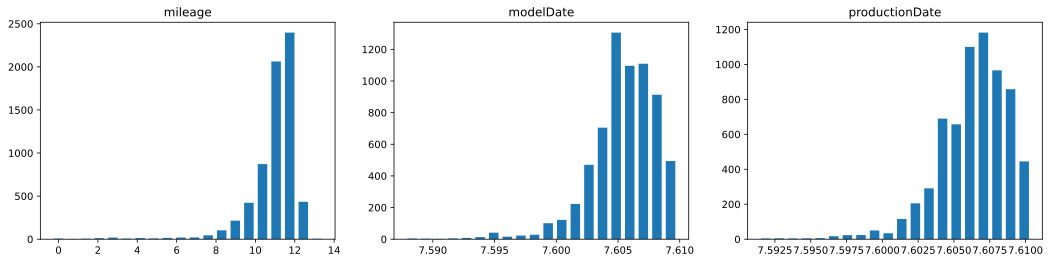

In [15]:
# Посмотрим сразу на логарифмированные числовые признаки
visualize_distributions({
    'mileage': np.log(train['mileage'].dropna()),
    'modelDate': np.log(train['modelDate'].dropna()),
    'productionDate': np.log(train['productionDate'].dropna())
})

Итого:
* CatBoost сможет работать с признаками и в таком виде, но для нейросети нужны нормированные данные.

In [16]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1 # помечаем трейн
test['sample'] = 0 # помечаем тест
test['price'] = 0 # заполним нулями значения таргета в тестовом датасете

data = test.append(train, sort=False).reset_index(drop=True) # объединяем
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


In [17]:
# используем модуль для быстрого первичного анализа данных https://pandas-profiling.ydata.ai/docs/master/index.html
import pandas_profiling
# pandas_profiling.ProfileReport(data)

Краткий итог: в тренировочной выборке 6682 объявлений, в тестовой - 1671. Всего данных - 8353 объявлений. Имеется 23 признака. Из числовых признаков у нас: mileage, modelDate, numberOfDoors, productionDate. Остальные - типа Object. Пропуски в признаках Владельцы и Владение. Также добавился признак sample для обозначения принадлежности данных и последующего разделения

# PreProc Tabular Data

In [18]:
display(data.shape)
data.head(3)

(8353, 23)

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,sample,price
0,универсал 5 дв.,MERCEDES,чёрный,Всем привет!\n\nПродам эксклюзивный проект 124...,3.0 LTR,220 N12,бензин,350000,1984,W124,300 3.0 AT (220 л.с.),5,1991,1099427284,WAGON_5_DOORS AUTOMATIC 3.0,автоматическая,3 или более,6 лет и 3 месяца,Оригинал,задний,Левый,0,0.0
1,купе,BMW,белый,Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...,3.0 LTR,313 N12,дизель,15000,2011,6ER,640d xDrive 3.0d AT (313 л.с.) 4WD,2,2013,1096405886,COUPE AUTOMATIC 3.0,автоматическая,1 владелец,6 лет и 6 месяцев,Оригинал,полный,Левый,0,0.0
2,купе,BMW,пурпурный,"Машина тут продаётся не в первый раз, НО! Толь...",2.5 LTR,218 N12,бензин,166600,2005,3ER,325xi 2.5 AT (218 л.с.) 4WD,2,2008,1100195294,COUPE AUTOMATIC 2.5,автоматическая,3 или более,NaN,Оригинал,полный,Левый,0,0.0


#### bodyType 

In [20]:
print('Пропусков данных:', data.bodyType.isnull().sum())
print('Unique bodyType:')
pprint(sorted(data.bodyType.unique().tolist()))

Пропусков данных: 0
Unique bodyType:
['внедорожник 3 дв.',
 'внедорожник 5 дв.',
 'внедорожник открытый',
 'кабриолет',
 'компактвэн',
 'купе',
 'купе-хардтоп',
 'лимузин',
 'лифтбек',
 'минивэн',
 'пикап двойная кабина',
 'родстер',
 'седан',
 'седан 2 дв.',
 'универсал 5 дв.',
 'хэтчбек 3 дв.',
 'хэтчбек 5 дв.']


In [21]:
data['bodyType'] = data['bodyType'].astype(str).apply(lambda x: None if x.strip() == '' else x)
data['bodyType'] = data.bodyType.apply(lambda x: x.split(' ')[0].lower())

In [22]:
# Посмотрим различаются ли средние цены на следующие категории кузовов: 'купе' и 'купе-хардтоп'
print('купе:', np.round(data.loc[(data['sample'] == 1) & (data['bodyType'] == 'купе')].price.mean()))
print('купе-хардтоп:', np.round(data.loc[(data['sample'] == 1) & (data['bodyType'] == 'купе-хардтоп')].price.mean()))

купе: 2402312.0
купе-хардтоп: 1408480.0


Ввиду того, что средние цены этих типов кузовов значительно отличаются, то объединять их не будем в одну категорию "купе"

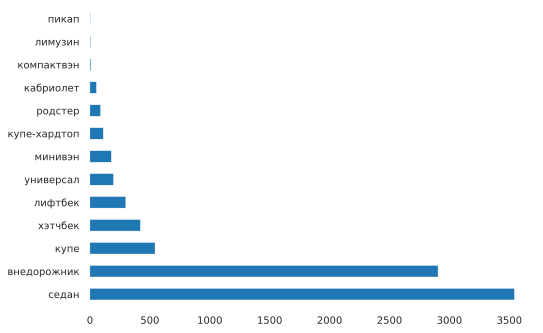

In [23]:
# посмотрим на распределение
data.bodyType.value_counts().plot.barh() 

#### color 

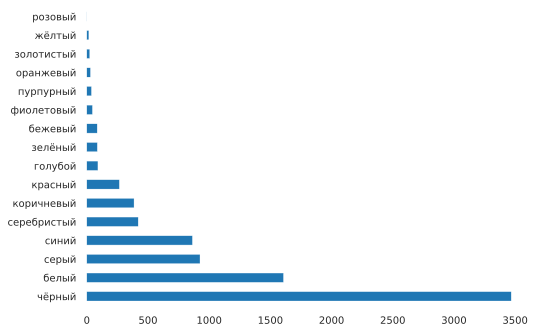

In [24]:
# посмотрим на распределение
data.color.value_counts().plot.barh()

#### engineDisplacement 

In [25]:
data.engineDisplacement.value_counts()

2.0 LTR          2430
3.0 LTR          2349
1.8 LTR           411
1.6 LTR           410
4.4 LTR           329
5.5 LTR           268
3.5 LTR           250
2.5 LTR           248
2.1 LTR           221
4.0 LTR           153
4.7 LTR           137
1.4 LTR           106
2.8 LTR           106
4.2 LTR           103
5.0 LTR            74
1.5 LTR            73
3.2 LTR            60
2.2 LTR            58
4.8 LTR            57
2.9 LTR            50
2.4 LTR            44
3.1 LTR            44
6.2 LTR            40
6.0 LTR            37
5.4 LTR            33
1.2 LTR            33
1.3 LTR            32
2.7 LTR            24
4.1 LTR            23
3.6 LTR            23
1.7 LTR            15
3.7 LTR            14
2.3 LTR            14
5.2 LTR            13
5.9 LTR            11
2.6 LTR             9
undefined LTR       6
0.7 LTR             6
6.6 LTR             5
1.9 LTR             5
4.6 LTR             5
5.8 LTR             5
3.4 LTR             4
4.3 LTR             4
3.8 LTR             3
5.6 LTR   

In [26]:
# удалим из значения признака строку LTR и заменим undefined на самое частотное значение
data.engineDisplacement = data.engineDisplacement.apply(lambda s: s.split(' ')[0])

engineDisplacement_top = data.engineDisplacement.describe()['top']
data = data.replace({'engineDisplacement': 'undefined'}, engineDisplacement_top)

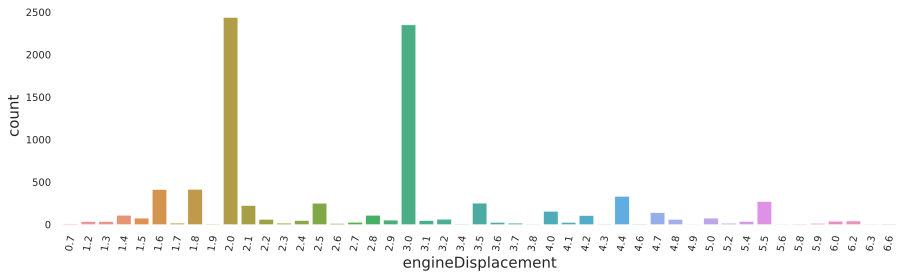

In [27]:
plt.figure(figsize=(15,4))
b = sns.countplot(x = 'engineDisplacement', data = data)
b.set_xlabel("engineDisplacement",fontsize=15)
b.set_ylabel("count",fontsize=15)
b.tick_params(labelsize=10)
plt.xticks(rotation=80)
plt.show()

Из распределения признака видно, что самыми покупаемыми авто являются авто с объемом двигателя 2.0 и 3.0 литра. Далее с большим отрывом (более чем в 5 раз) идут движки с объемом 1.8 и 1.6 литра.

#### enginePower 

In [28]:
data.enginePower.unique()

array(['220 N12', '313 N12', '218 N12', '136 N12', '190 N12', '340 N12',
       '245 N12', '316 N12', '170 N12', '160 N12', '231 N12', '388 N12',
       '180 N12', '367 N12', '115 N12', '184 N12', '177 N12', '455 N12',
       '422 N12', '163 N12', '249 N12', '272 N12', '224 N12', '122 N12',
       '557 N12', '333 N12', '306 N12', '156 N12', '150 N12', '264 N12',
       '450 N12', '555 N12', '407 N12', '130 N12', '400 N12', '204 N12',
       '469 N12', '192 N12', '210 N12', '211 N12', '239 N12', '200 N12',
       '350 N12', '420 N12', '300 N12', '381 N12', '265 N12', '258 N12',
       '390 N12', '197 N12', '120 N12', '544 N12', '193 N12', '235 N12',
       '233 N12', '394 N12', '355 N12', '421 N12', '320 N12', '585 N12',
       '105 N12', '280 N12', '194 N12', '132 N12', '639 N12', '250 N12',
       '335 N12', '510 N12', '116 N12', '360 N12', '238 N12', '225 N12',
       '625 N12', '571 N12', '507 N12', '286 N12', '372 N12', '575 N12',
       '408 N12', '310 N12', '354 N12', '255 N12', 

In [29]:
# предобработаем "enginePower"
data['enginePower'] = data['enginePower'].apply(lambda s: s.split(' ')[0]).astype('int')

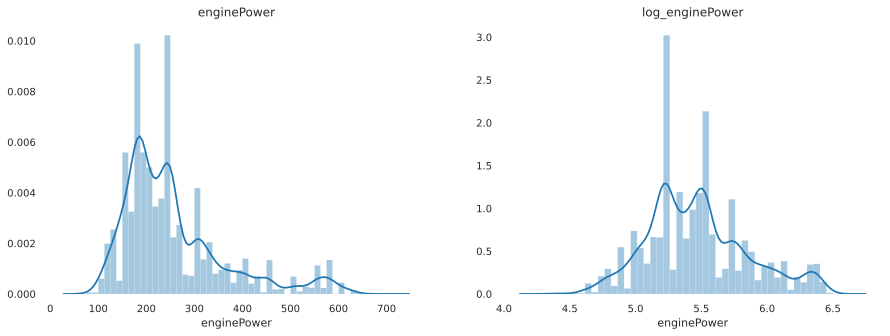

In [30]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title('enginePower')
sns.distplot(data['enginePower'])
plt.subplot(1, 2, 2)
plt.title('log_enginePower')
sns.distplot(np.log(data['enginePower']))

Добавим прологарифмированный признак к числовым (numerical_features). При обработке числовых признаков возьмем от логарифм от признака, так как его рампределение ближе к нормальному.

#### fuelType 

In [32]:
data.fuelType.value_counts()

бензин     6018
дизель     2315
гибрид       14
электро       6
Name: fuelType, dtype: int64

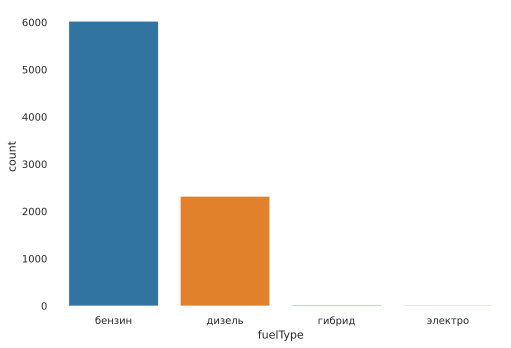

In [33]:
sns.countplot(x = 'fuelType', data = data)

В лидерах бензиновые авто, далее дизель с отставанием в 3 раза. Остальные виды топлива почти не представлены в объединенном датасете.

#### mileage 

In [34]:
data['mileage'].describe()

count       8353.000000
mean      120362.983479
std        81856.639133
min            1.000000
25%        59246.000000
50%       110384.000000
75%       167084.000000
max      1000000.000000
Name: mileage, dtype: float64

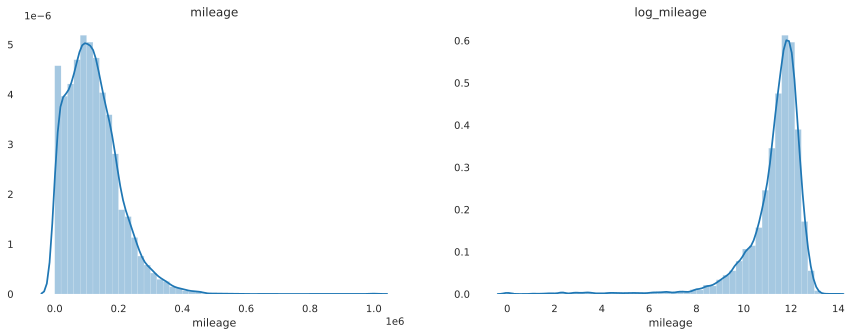

In [35]:
# Посмотрим на распредение признака mileage и его логарифмированной версии
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title('mileage')
sns.distplot(data['mileage'])
plt.subplot(1, 2, 2)
plt.title('log_mileage')
sns.distplot(np.log(data['mileage']))

Использовать будем признак без изменений, так как логарифмирование не улучшило его разпределение. В признаке имеются выбросы.

#### modelDate 

In [36]:
data['modelDate'].describe()

count    8353.000000
mean     2010.103556
std         5.436914
min      1971.000000
25%      2007.000000
50%      2011.000000
75%      2014.000000
max      2019.000000
Name: modelDate, dtype: float64

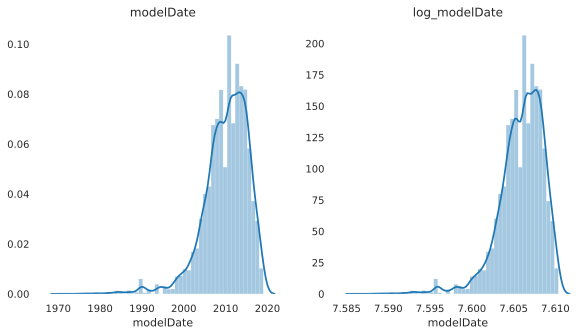

In [37]:
# Посмотрим на распредение признака modelDate и его логарифмированной версии
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title('modelDate')
sns.distplot(data['modelDate'])
plt.subplot(1, 3, 2)
plt.title('log_modelDate')
sns.distplot(np.log(data['modelDate']))

Основная масса авто принадлежат к авто 2015 - 2018хх модельных годов.

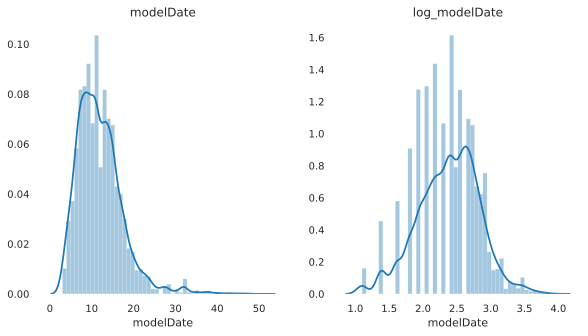

In [38]:
# Посмотрим на распредение признака modelDate и его логарифмированной версии
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title('modelDate')
sns.distplot(2022 - data['modelDate'])
plt.subplot(1, 3, 2)
plt.title('log_modelDate')
sns.distplot(np.log(2022 - data['modelDate']))

На графике распределения представлены не исходные значения признака, а разница между 2022 годом и значением признака. Данные значения можно трактовать на сколько данная модель сважая и уже устаревшая. Логарифм не улучшил распределение признака.

#### productionDate 

In [39]:
data['productionDate'].describe()

count    8353.000000
mean     2012.010775
std         5.107314
min      1982.000000
25%      2009.000000
50%      2013.000000
75%      2016.000000
max      2020.000000
Name: productionDate, dtype: float64

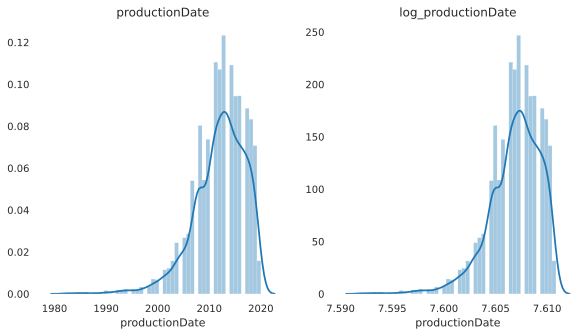

In [40]:
# Посмотрим на распредение признака productionDate и его логарифмированной версии
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title('productionDate')
sns.distplot(data['productionDate'])
plt.subplot(1, 3, 2)
plt.title('log_productionDate')
sns.distplot(np.log(data['productionDate']))

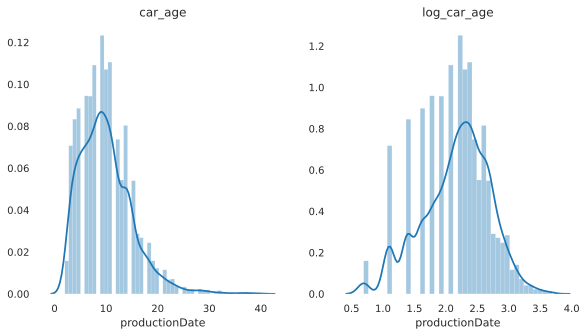

In [41]:
# Посмотрим на распредение признака modelDate и его логарифмированной версии
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title('car_age')
sns.distplot(2022 - data['productionDate'])
plt.subplot(1, 3, 2)
plt.title('log_car_age')
sns.distplot(np.log(2022 - data['productionDate']))

Основная масса авто произведена с 2009 по 2016 года. Логарифмирование признака не улучшило распределение. Из данного признака можно сгенерировать новый - возраст авто, который будет разницей между 2022 и годом производства авто (car_age). 

#### numberOfDoors 

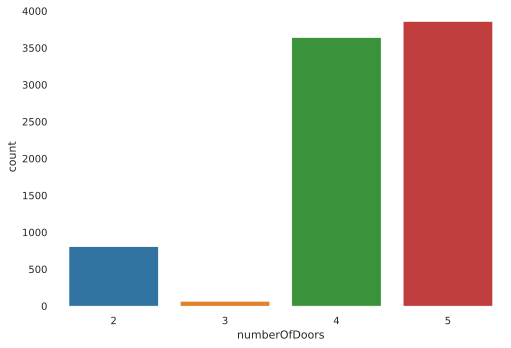

In [42]:
sns.countplot(x = 'numberOfDoors', data = data)

Из графика видно что авто с 5-ю и 4-мя дверьми самые покупаемые.

#### vehicleTransmission 

In [43]:
data.vehicleTransmission.unique()

array(['автоматическая', 'вариатор', 'роботизированная', 'механическая'],
      dtype=object)

Заменим виды трансмиссией на абревиатуры автоматическая - AT, вариатор - CVT, роботизированная - AMT, механическая - MT

In [44]:
transmission_dict = {
    'автоматическая': 'AT',
    'вариатор': 'CVT',
    'роботизированная': 'AMT',
    'механическая': 'MT',
}

data.vehicleTransmission = data.vehicleTransmission.apply(lambda key: transmission_dict[key])

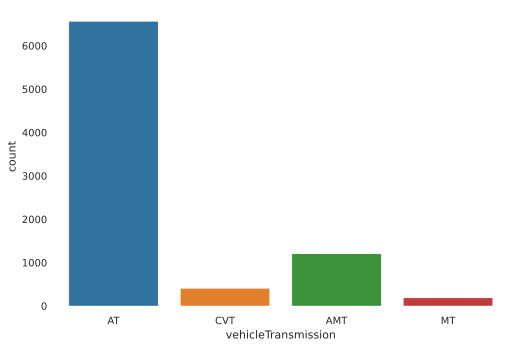

In [45]:
sns.countplot(x = 'vehicleTransmission', data = data)

 Авто с коробной автомат лидируют со значительным отрывом от других типов автоматических трансмиссий.  Стоит создать новый признак, автомат или механика. В категорию "автомат" войдут авто с автоматической КПП, вариатором и роботом, так как это все вариации автоматической трансмиссии и они, по моему предположению, должны быть дороже чем механика.

#### Владельцы 

In [46]:
print(f"пропущенных данных: {data['Владельцы'].isnull().sum()}\n")
print('Describe:\n', data['Владельцы'].describe(), '\n')
data['Владельцы'].value_counts()

пропущенных данных: 1

Describe:
 count            8352
unique              3
top       3 или более
freq             3311
Name: Владельцы, dtype: object 



3 или более    3311
1 владелец     2526
2 владельца    2515
Name: Владельцы, dtype: int64

In [47]:
# преобразуем данные, оставим только числовое значение
data['Владельцы'].fillna(data['Владельцы'].describe().top, inplace=True)
data['Владельцы'] = data['Владельцы'].apply(lambda s: s.replace(u'\xa0', u' ').split(' ')[0]).astype('int8')

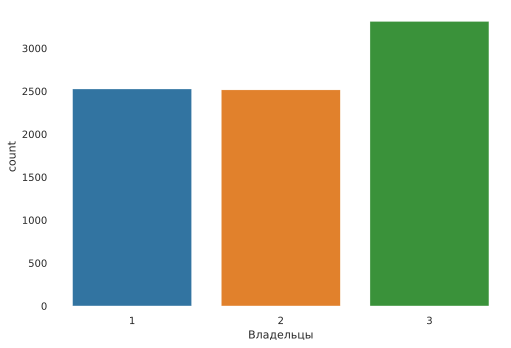

In [48]:
sns.countplot(x = 'Владельцы', data = data)

#### Владение 

In [49]:
data['Владение'].isnull().sum()

5418

Признак имеет очень большое кол-во пропусков - его стоит удалить.

In [50]:
# categorical_features.remove('Владение')

#### ПТС 

пропущенных данных: 0



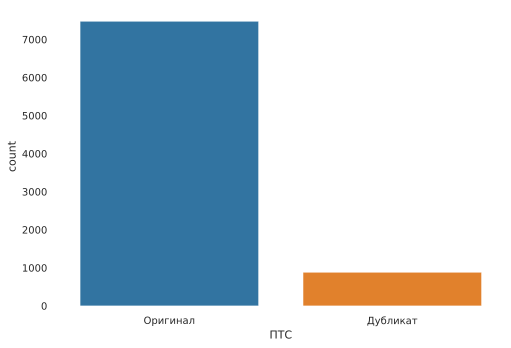

In [51]:
print(f"пропущенных данных: {data['ПТС'].isnull().sum()}\n")
sns.countplot(x = 'ПТС', data = data)

#### Привод 

пропущенных данных: 0



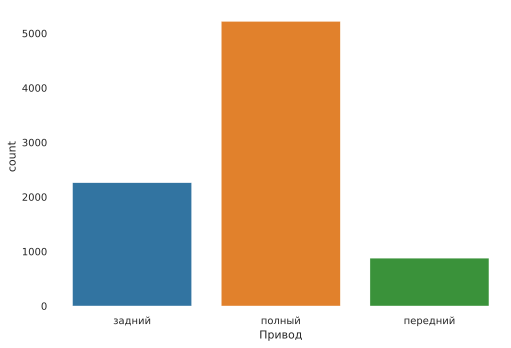

In [52]:
print(f"пропущенных данных: {data['Привод'].isnull().sum()}\n")
sns.countplot(x = 'Привод', data = data)

#### Руль 

пропущенных данных: 0



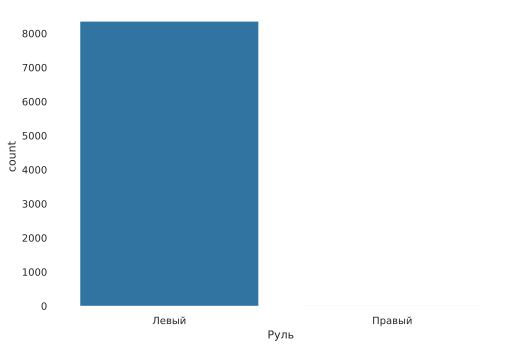

In [53]:
print(f"пропущенных данных: {data['Руль'].isnull().sum()}\n")
sns.countplot(x = 'Руль', data = data)

In [54]:
#  посмотрим есть ли среди тестовой выборки авто с правым рулем. Если таких нет, то стоит вообще удалить объекты с правим рулем и трейна.
data.loc[(data['sample'] == 0) & (data['Руль'] == 'Правый')].shape

(0, 23)

В тестовой выборке вообще нет объектов с правым рулем. Стоит полностью удалить данный признак.

#### vehicleConfiguration 

In [56]:
# vehicleConfiguration
print(f"пропущенных данных: {data['vehicleConfiguration'].isnull().sum()}\n")
data.vehicleConfiguration.sample(10)

пропущенных данных: 0



7399      ALLROAD_5_DOORS AUTOMATIC 2.0
4273      ALLROAD_5_DOORS AUTOMATIC 2.0
3362                SEDAN AUTOMATIC 5.5
2794                    SEDAN ROBOT 3.0
5378                SEDAN AUTOMATIC 2.0
5902        WAGON_5_DOORS AUTOMATIC 4.0
1454                SEDAN AUTOMATIC 3.0
2476                SEDAN AUTOMATIC 2.5
743     HATCHBACK_5_DOORS AUTOMATIC 1.6
1168      ALLROAD_5_DOORS AUTOMATIC 5.5
Name: vehicleConfiguration, dtype: object

Данный признак - это комбинация других столбцов, поэтому он не представляет никакой ценности. 

#### model_info 

In [57]:
print(f"N/A values: {data['model_info'].isnull().sum()}")
print(f"Unique values: {data.model_info.nunique()}\n")
pprint(sorted(data.model_info.unique().tolist()))

N/A values: 0
Unique values: 122

['100',
 '1ER',
 '2ACTIVETOURER',
 '2ER',
 '2GRANDTOURER',
 '3ER',
 '4',
 '5ER',
 '6ER',
 '7ER',
 '8ER',
 'A1',
 'A3',
 'A4',
 'A4_ALLROAD',
 'A5',
 'A6',
 'A7',
 'A8',
 'ALLROAD',
 'AMG_GLC_COUPE',
 'AMG_GT',
 'A_KLASSE',
 'A_KLASSE_AMG',
 'B_KLASSE',
 'CITAN',
 'CLA_KLASSE',
 'CLA_KLASSE_AMG',
 'CLC_KLASSE',
 'CLK_KLASSE',
 'CLS_KLASSE',
 'CLS_KLASSE_AMG',
 'CL_KLASSE',
 'CL_KLASSE_AMG',
 'COUPE',
 'C_KLASSE',
 'C_KLASSE_AMG',
 'E_KLASSE',
 'E_KLASSE_AMG',
 'GLA_CLASS',
 'GLA_CLASS_AMG',
 'GLC_COUPE',
 'GLC_KLASSE',
 'GLC_KLASSE_AMG',
 'GLE_KLASSE',
 'GLE_KLASSE_AMG',
 'GLE_KLASSE_COUPE',
 'GLE_KLASSE_COUPE_AMG',
 'GLK_KLASSE',
 'GLS_KLASSE',
 'GLS_KLASSE_AMG',
 'GL_KLASSE',
 'GL_KLASSE_AMG',
 'G_KLASSE',
 'G_KLASSE_AMG',
 'I3',
 'I8',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M_KLASSE',
 'M_KLASSE_AMG',
 'None',
 'Q3',
 'Q5',
 'Q7',
 'Q8',
 'R8',
 'RS3',
 'RS4',
 'RS5',
 'RS6',
 'RS7',
 'RSQ3',
 'R_KLASSE',
 'S3',
 'S4',
 'S5',
 'S6',
 'S7',
 'S8'

In [58]:
# Узнаем сколько объектов со значением None
data.loc[data.model_info == 'None']

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,sample,price
2803,седан,MERCEDES,серый,Автомобиль в очень хорошем состоянии. Богатая ...,4.0,510,бензин,41000,2014,None,63 AMG S 4.0 AT (510 л.с.),4,2017,1099323364,SEDAN AUTOMATIC 4.0,AT,3,NaN,Дубликат,задний,Левый,1,3700000.0


Имеем пропуск. Попробуем заполнить его самым частотным значением из выборки с одинаковым значением признака name

In [59]:
top_model_value = data.loc[data.name == data.loc[data.model_info == 'None'].name.values.tolist()[0]].model_info.describe()['top']
print(f"Top value: {top_model_value}")

# replace None value with top_model_value
data = data.replace({'model_info': 'None'}, top_model_value)

Top value: C_KLASSE_AMG


#### name 

In [60]:
print(f"N/A values: {data['name'].isnull().sum()}")
print(f"Unique values: {data.name.nunique()}\n")
pprint(sorted(data.name.unique().tolist()))

N/A values: 0
Unique values: 976

['0.7hyb AT (170 л.с.)',
 '1.2 AMT (105 л.с.)',
 '1.2 AMT (110 л.с.)',
 '1.4 AMT (122 л.с.)',
 '1.4 AMT (125 л.с.)',
 '1.4 AMT (150 л.с.)',
 '1.4 MT (125 л.с.)',
 '1.5 AT (136 л.с.)',
 '1.5hyb AT (231 л.с.) 4WD',
 '1.6 AMT (102 л.с.)',
 '1.6 AT (102 л.с.)',
 '1.6 MT (101 л.с.)',
 '1.6 MT (102 л.с.)',
 '1.8 AMT (160 л.с.)',
 '1.8 AMT (180 л.с.)',
 '1.8 AMT (180 л.с.) 4WD',
 '1.8 AMT (190 л.с.)',
 '1.8 AT (109 л.с.)',
 '1.8 AT (163 л.с.) 4WD',
 '1.8 AT (170 л.с.)',
 '1.8 AT (170 л.с.) 4WD',
 '1.8 AT (180 л.с.)',
 '1.8 CVT (120 л.с.)',
 '1.8 CVT (160 л.с.)',
 '1.8 CVT (163 л.с.)',
 '1.8 CVT (170 л.с.)',
 '1.8 CVT (177 л.с.)',
 '1.8 MT (120 л.с.)',
 '1.8 MT (150 л.с.)',
 '1.8 MT (160 л.с.)',
 '1.8 MT (163 л.с.)',
 '1.8 MT (163 л.с.) 4WD',
 '1.8 MT (170 л.с.) 4WD',
 '1.8 MT (180 л.с.)',
 '1.8 MT (190 л.с.) 4WD',
 '1.8 MT (225 л.с.) 4WD',
 '1.9 AT (140 л.с.)',
 '1.9 MT (140 л.с.)',
 '1.9d AMT (105 л.с.)',
 '108 CDI 1.5d MT (75 л.с.)',
 '108 CDI 2.2d MT (82 л

In [61]:
# экстра длинный, длинный, компактный, L3, L2, L1, Long, Pullman -> MERCEDES
# Long -> AUDI
# xDrive -> BMW

# Доработать в признаке (длинный в L2), (экстра длинный -> L3), (компактный -> L1)
# выделить из признака name отдельные признаки: xDrive, Pullman, , L3, L2, L1, Long, Competition, AMG


При визуальном анализе признака name заметил, что описании где то указано "компактный" или  "длинный"  или "экстра длинный", что соответствует обозначениям "L1", "L2", "L3" соответственно, которые так же встречаются в данных.  Для справки: экстра длинный, длинный, компактный, L3, L2, L1, Long - это все обозначения длины кузова одного производителя - MERCEDES.  
Например:  
- **250 d длинный 2.1d AT (190 л.с.)**
- **200 d компактный 2.1d AT (136 л.с.)**  
- **L1 2.1d AT (163 л.с.) 4WD**  
- **L3 2.1d AT (163 л.с.)**  
Так как есть желание вынести данные значения в отдельный признак, то для уменьшения размерности заменим значения компактный, длинный, экстра длинный на L1, L2, L3 соответственно.

In [62]:
body_length_dict = {
    'компактный': 'L1',
    'длинный': 'L2',
    'экстра длинный': 'L3',
}

def preproc_name(s):
    for key in ['компактный', 'экстра длинный', 'длинный']:
        if key in s:
            s = s.replace(key, body_length_dict[key])
            return s
    return s
    
    
data.name = data.name.apply(preproc_name)

#### price - целевая переменная 

count    6.682000e+03
mean     1.899868e+06
std      1.914153e+06
min      3.013010e+05
25%      8.000000e+05
50%      1.300000e+06
75%      2.299283e+06
max      2.390000e+07
Name: price, dtype: float64

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


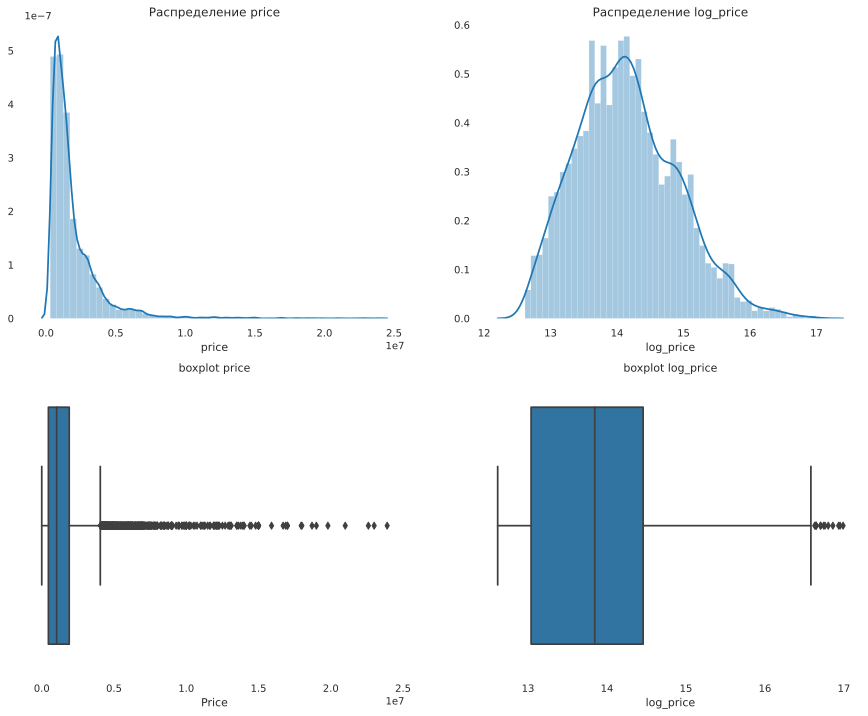

In [63]:
display(data[data['sample'] == 1]['price'].describe())
plt.figure(figsize=(15, 12))
plt.subplot(2,2,1)
plt.title(f"Распределение {'price'}")
sns.distplot(data[data['sample'] == 1]['price'], bins=50)

plt.subplot(2,2,2)
plt.title(f"Распределение {'log_price'}")
b = sns.distplot(np.log(data[data['sample'] == 1]['price']), bins=50)
b.set_xlabel("log_price",fontsize=11)

plt.subplot(2,2,3)
sns.boxplot(data['price'])
plt.xlabel('Price')
plt.title(f"boxplot {'price'}", fontsize=11)

plt.subplot(2,2,4)
c = sns.boxplot(np.log(data['price']))
b.set_xlabel("log_price",fontsize=11)
plt.xlabel('log_price')
plt.title(f"boxplot {'log_price'}", fontsize=11)
plt.show()

log_price имеет более нормальное распределение. Стоит учитывать это при выборе таргета для обучения моделей.

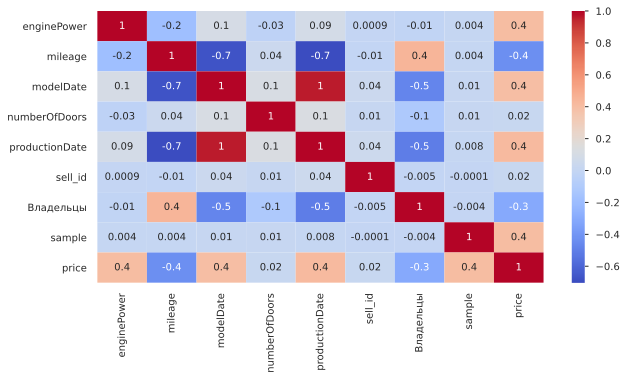

In [64]:
# корреляция

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax = sns.heatmap(data.corr(),fmt='.1g',
                 annot=True, cmap='coolwarm')

На графике коррелации видно, что признаки modelDate и productionDate имеют 100% корреляцию. И это логично, ведь признак modelDate по своей сути всегда открывает период производства модели на протяжении следующих n-лет. После этапа feature engineering проведем корр.анализ еще раз. После чего будем решать какие признаки удалять.

## Feature engineering 

In [65]:
data['log_enginePower'] = np.log(data['enginePower'])

In [66]:
# Возраст авто
data['car_age'] = 2022 - data['productionDate']

#  пробег авто за год
data['miles_per_year'] = np.round(data['mileage'] / data['car_age'], 2)

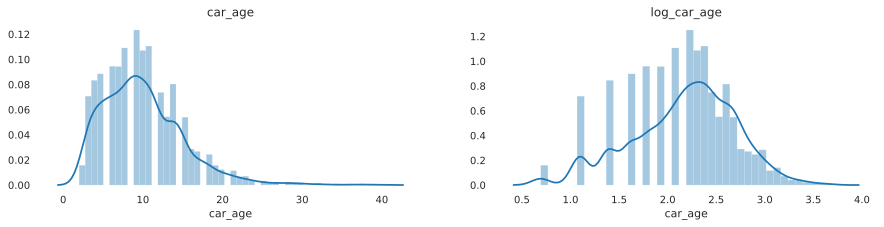

In [67]:
# Посмотрим на распредение признака car_age и его логарифма
plt.figure(figsize=(15, 3))
plt.subplot(1, 2, 1)
plt.title('car_age')
sns.distplot(data['car_age'])
plt.subplot(1, 2, 2)
plt.title('log_car_age')
sns.distplot(np.log(data['car_age']))

In [68]:
# log_car_age имеет распределение, близкое к нормальному. Добавим данный признак в датафрейм
data['log_car_age'] = np.log(data['car_age'])

count     8353.000000
mean     11632.329690
std       5794.328176
min          0.250000
25%       7800.000000
50%      11356.360000
75%      15111.110000
max      71428.500000
Name: miles_per_year, dtype: float64

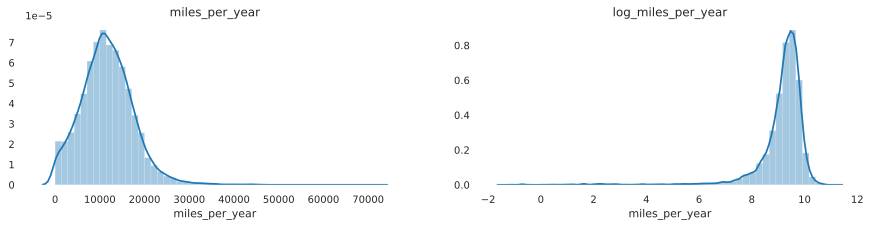

In [69]:
# Посмотрим на распредение признака model_age и его логарифма
display(data['miles_per_year'].describe())

plt.figure(figsize=(15, 3))
plt.subplot(1, 2, 1)
plt.title('miles_per_year')
sns.distplot(data['miles_per_year'])
plt.subplot(1, 2, 2)
plt.title('log_miles_per_year')
sns.distplot(np.log(data['miles_per_year']))

Из графика распределения пробега в год видно, что большая часть авто имеет годовой пробег на уровне 10-13 тыс. км, но небольшая часть имеет пробеги от 30 до 70 тыс. км. Распределение не нормальное с хвостом справа. Логарифм не улучшил распределение. Будем использовать исходное значения.

In [70]:
# создадим отдельный признак на основе данных из признака name. Далее сделаем из него категориальный
data['unique_feature'] = np.nan
def fill_unique_feature(s):
    for item in 'xDrive Pullman L1 L2 L3 Long Competition AMG'.split(' '):
        if item in s:
            return item
    return 'other'
data['unique_feature'] = data.name.apply(fill_unique_feature)

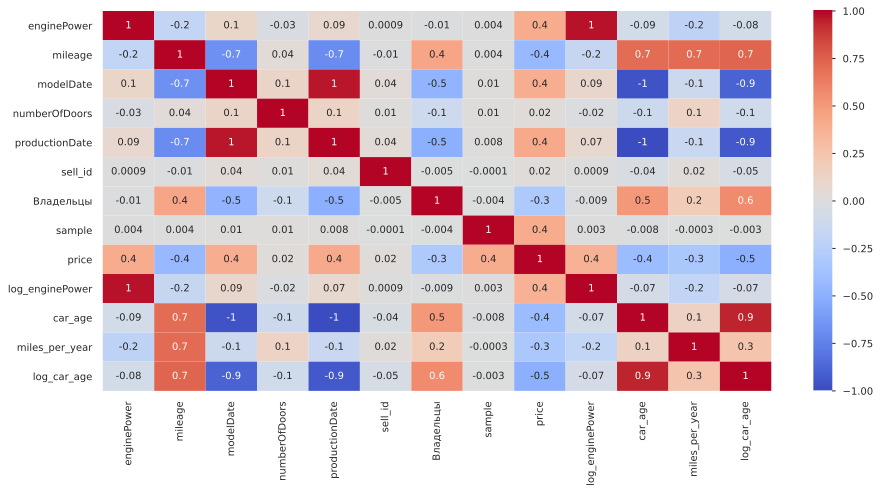

In [71]:
# корреляция

fig, ax = plt.subplots(1, 1, figsize=(15, 7))
ax = sns.heatmap(data.corr(),fmt='.1g',
                 annot=True, cmap='coolwarm')

Из корреляционной матрицы видно, что следующие признаки имеют высокую корреляцию между собой:  
- modelDate и productionDate и car_age  
Стоит оставить только один из трех признаков. По моему мнению, самым оптимальным признаком является признак возраст авто car_age.  
Оставим его.

In [73]:
# Посмотрим на получившиеся данные
data.head(5)

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,sample,price,log_enginePower,car_age,miles_per_year,log_car_age,unique_feature
0,универсал,MERCEDES,чёрный,Всем привет!\n\nПродам эксклюзивный проект 124...,3.0,220,бензин,350000,1984,W124,300 3.0 AT (220 л.с.),5,1991,1099427284,WAGON_5_DOORS AUTOMATIC 3.0,AT,3,6 лет и 3 месяца,Оригинал,задний,Левый,0,0.0,5.393628,31,11290.32,3.433987,other
1,купе,BMW,белый,Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...,3.0,313,дизель,15000,2011,6ER,640d xDrive 3.0d AT (313 л.с.) 4WD,2,2013,1096405886,COUPE AUTOMATIC 3.0,AT,1,6 лет и 6 месяцев,Оригинал,полный,Левый,0,0.0,5.746203,9,1666.67,2.197225,xDrive
2,купе,BMW,пурпурный,"Машина тут продаётся не в первый раз, НО! Толь...",2.5,218,бензин,166600,2005,3ER,325xi 2.5 AT (218 л.с.) 4WD,2,2008,1100195294,COUPE AUTOMATIC 2.5,AT,3,NaN,Оригинал,полный,Левый,0,0.0,5.384495,14,11900.00,2.639057,other
3,седан,BMW,белый,"Автомобиль в отличном состоянии, весь в родной...",2.0,136,бензин,147000,2005,3ER,318i 2.0 AT (136 л.с.),4,2007,1099827282,SEDAN AUTOMATIC 2.0,AT,2,NaN,Оригинал,задний,Левый,0,0.0,4.912655,15,9800.00,2.708050,other
4,седан,BMW,чёрный,Немка! с бесключивым доступом и камерой заднег...,2.0,190,дизель,24000,2016,5ER,520d xDrive 2.0d AT (190 л.с.) 4WD,4,2019,1100076198,SEDAN AUTOMATIC 2.0,AT,1,NaN,Оригинал,полный,Левый,0,0.0,5.247024,3,8000.00,1.098612,xDrive


In [75]:
numerical_features = ['log_enginePower', 'mileage', 'log_car_age', 'miles_per_year']
categorical_features = ['bodyType', 'brand', 'color', 'engineDisplacement', 'fuelType', 'model_info',
                        'numberOfDoors', 'vehicleTransmission', 'Владельцы', 'ПТС', 'Привод', 'unique_feature']

In [77]:
def preproc_data(df_input):
    '''includes several functions to pre-process the predictor data.'''
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['enginePower', 'description','modelDate', 'name', 'car_age', 'productionDate', 'sell_id', 'vehicleConfiguration', 'Владение', 'Руль'], axis = 1, inplace=True)
    
    
    # ################### Numerical Features ############################################################## 
    # Нормализация данных
    scaler = RobustScaler()  # применим именно эту стандартизацию,тк она устойчива к выбросам
    for column in numerical_features:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
    
    # ################### Categorical Features ############################################################## 
    # Label Encoding
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes
        
    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df_output = pd.get_dummies(df_output, columns=categorical_features, dummy_na=False)
    
    return df_output

In [78]:
# Запускаем и проверяем, что получилось
df_preproc = preproc_data(data)
df_preproc.sample(10)

,mileage,sample,price,log_enginePower,miles_per_year,log_car_age,bodyType_0,bodyType_1,bodyType_2,bodyType_3,bodyType_4,bodyType_5,bodyType_6,bodyType_7,bodyType_8,bodyType_9,bodyType_10,bodyType_11,bodyType_12,brand_0,brand_1,brand_2,color_0,color_1,color_2,color_3,color_4,color_5,color_6,color_7,color_8,color_9,color_10,color_11,color_12,color_13,color_14,color_15,engineDisplacement_0,engineDisplacement_1,engineDisplacement_2,engineDisplacement_3,engineDisplacement_4,engineDisplacement_5,engineDisplacement_6,engineDisplacement_7,engineDisplacement_8,engineDisplacement_9,engineDisplacement_10,engineDisplacement_11,engineDisplacement_12,engineDisplacement_13,engineDisplacement_14,engineDisplacement_15,engineDisplacement_16,engineDisplacement_17,engineDisplacement_18,engineDisplacement_19,engineDisplacement_20,engineDisplacement_21,engineDisplacement_22,engineDisplacement_23,engineDisplacement_24,engineDisplacement_25,engineDisplacement_26,engineDisplacement_27,engineDisplacement_28,engineDisplacement_29,engineDisplacement_30,engineDisplacement_31,engineDisplacement_32,engineDisplacement_33,engineDisplacement_34,engineDisplacement_35,engineDisplacement_36,engineDisplacement_37,engineDisplacement_38,engineDisplacement_39,engineDisplacement_40,engineDisplacement_41,engineDisplacement_42,engineDisplacement_43,engineDisplacement_44,engineDisplacement_45,engineDisplacement_46,fuelType_0,fuelType_1,fuelType_2,fuelType_3,model_info_0,model_info_1,model_info_2,model_info_3,model_info_4,model_info_5,model_info_6,model_info_7,model_info_8,model_info_9,model_info_10,model_info_11,model_info_12,model_info_13,model_info_14,model_info_15,model_info_16,model_info_17,model_info_18,model_info_19,model_info_20,model_info_21,model_info_22,model_info_23,model_info_24,model_info_25,model_info_26,model_info_27,model_info_28,model_info_29,model_info_30,model_info_31,model_info_32,model_info_33,model_info_34,model_info_35,model_info_36,model_info_37,model_info_38,model_info_39,model_info_40,model_info_41,model_info_42,model_info_43,model_info_44,model_info_45,model_info_46,model_info_47,model_info_48,model_info_49,model_info_50,model_info_51,model_info_52,model_info_53,model_info_54,model_info_55,model_info_56,model_info_57,model_info_58,model_info_59,model_info_60,model_info_61,model_info_62,model_info_63,model_info_64,model_info_65,model_info_66,model_info_67,model_info_68,model_info_69,model_info_70,model_info_71,model_info_72,model_info_73,model_info_74,model_info_75,model_info_76,model_info_77,model_info_78,model_info_79,model_info_80,model_info_81,model_info_82,model_info_83,model_info_84,model_info_85,model_info_86,model_info_87,model_info_88,model_info_89,model_info_90,model_info_91,model_info_92,model_info_93,model_info_94,model_info_95,model_info_96,model_info_97,model_info_98,model_info_99,model_info_100,model_info_101,model_info_102,model_info_103,model_info_104,model_info_105,model_info_106,model_info_107,model_info_108,model_info_109,model_info_110,model_info_111,model_info_112,model_info_113,model_info_114,model_info_115,model_info_116,model_info_117,model_info_118,model_info_119,model_info_120,numberOfDoors_0,numberOfDoors_1,numberOfDoors_2,numberOfDoors_3,vehicleTransmission_0,vehicleTransmission_1,vehicleTransmission_2,vehicleTransmission_3,Владельцы_0,Владельцы_1,Владельцы_2,ПТС_0,ПТС_1,Привод_0,Привод_1,Привод_2,unique_feature_0,unique_feature_1,unique_feature_2,unique_feature_3,unique_feature_4,unique_feature_5,unique_feature_6,unique_feature_7,unique_feature_8
3640,1.044307,1,630000.0,-0.283300,0.625378,0.571441,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1

## Split data

In [80]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

In [81]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1671 entries, 0 to 1670
Columns: 234 entries, mileage to unique_feature_8
dtypes: float64(5), uint8(229)
memory usage: 452.0 KB


# Model 2: CatBoostRegressor

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [83]:
model = CatBoostRegressor(iterations = 15000,
                          #depth=10,
                          #learning_rate = 0.5,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=1000,
                         )
model.fit(X_train, np.log(y_train),
         eval_set=(X_test, np.log(y_test)),
         verbose_eval=100,
         use_best_model=True,
         )

Learning rate set to 0.01184
0:	learn: 0.0422619	test: 0.0423256	best: 0.0423256 (0)	total: 54.2ms	remaining: 13m 32s
100:	learn: 0.0195850	test: 0.0191531	best: 0.0191531 (100)	total: 461ms	remaining: 1m 8s
200:	learn: 0.0132386	test: 0.0129067	best: 0.0129067 (200)	total: 820ms	remaining: 1m
300:	learn: 0.0113808	test: 0.0110570	best: 0.0110570 (300)	total: 1.15s	remaining: 56s
400:	learn: 0.0106718	test: 0.0104177	best: 0.0104177 (400)	total: 1.46s	remaining: 53.3s
500:	learn: 0.0102661	test: 0.0100837	best: 0.0100837 (500)	total: 1.78s	remaining: 51.6s
600:	learn: 0.0100136	test: 0.0099013	best: 0.0099013 (600)	total: 2.1s	remaining: 50.3s
700:	learn: 0.0098134	test: 0.0097421	best: 0.0097421 (700)	total: 2.4s	remaining: 49.1s
800:	learn: 0.0096360	test: 0.0096071	best: 0.0096071 (800)	total: 2.71s	remaining: 48.1s
900:	learn: 0.0094675	test: 0.0094916	best: 0.0094913 (899)	total: 3.02s	remaining: 47.3s
1000:	learn: 0.0093093	test: 0.0093889	best: 0.0093889 (1000)	total: 3.34s	rema

In [84]:
test_predict_catboost = np.exp(model.predict(X_test))
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")

TEST mape: 11.28%


TEST mape: 12.58% при | iterations = 15000 | не логарифмированный price  
TEST mape: 11.43% при | iterations = 5000 | логарифмированный price  
TEST mape: 11.28% при | iterations = 15000 | логарифмированный price  
TEST mape: 11.36%  при | iterations = 20000 | логарифмированный price  


### Submission

In [85]:
sub_predict_catboost = np.exp(model.predict(X_sub))
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('catboost_submission.csv', index=False)

# Model 3: Tabular NN

Построим обычную сеть:

In [86]:
X_train.head(5)

,mileage,log_enginePower,miles_per_year,log_car_age,bodyType_0,bodyType_1,bodyType_2,bodyType_3,bodyType_4,bodyType_5,bodyType_6,bodyType_7,bodyType_8,bodyType_9,bodyType_10,bodyType_11,bodyType_12,brand_0,brand_1,brand_2,color_0,color_1,color_2,color_3,color_4,color_5,color_6,color_7,color_8,color_9,color_10,color_11,color_12,color_13,color_14,color_15,engineDisplacement_0,engineDisplacement_1,engineDisplacement_2,engineDisplacement_3,engineDisplacement_4,engineDisplacement_5,engineDisplacement_6,engineDisplacement_7,engineDisplacement_8,engineDisplacement_9,engineDisplacement_10,engineDisplacement_11,engineDisplacement_12,engineDisplacement_13,engineDisplacement_14,engineDisplacement_15,engineDisplacement_16,engineDisplacement_17,engineDisplacement_18,engineDisplacement_19,engineDisplacement_20,engineDisplacement_21,engineDisplacement_22,engineDisplacement_23,engineDisplacement_24,engineDisplacement_25,engineDisplacement_26,engineDisplacement_27,engineDisplacement_28,engineDisplacement_29,engineDisplacement_30,engineDisplacement_31,engineDisplacement_32,engineDisplacement_33,engineDisplacement_34,engineDisplacement_35,engineDisplacement_36,engineDisplacement_37,engineDisplacement_38,engineDisplacement_39,engineDisplacement_40,engineDisplacement_41,engineDisplacement_42,engineDisplacement_43,engineDisplacement_44,engineDisplacement_45,engineDisplacement_46,fuelType_0,fuelType_1,fuelType_2,fuelType_3,model_info_0,model_info_1,model_info_2,model_info_3,model_info_4,model_info_5,model_info_6,model_info_7,model_info_8,model_info_9,model_info_10,model_info_11,model_info_12,model_info_13,model_info_14,model_info_15,model_info_16,model_info_17,model_info_18,model_info_19,model_info_20,model_info_21,model_info_22,model_info_23,model_info_24,model_info_25,model_info_26,model_info_27,model_info_28,model_info_29,model_info_30,model_info_31,model_info_32,model_info_33,model_info_34,model_info_35,model_info_36,model_info_37,model_info_38,model_info_39,model_info_40,model_info_41,model_info_42,model_info_43,model_info_44,model_info_45,model_info_46,model_info_47,model_info_48,model_info_49,model_info_50,model_info_51,model_info_52,model_info_53,model_info_54,model_info_55,model_info_56,model_info_57,model_info_58,model_info_59,model_info_60,model_info_61,model_info_62,model_info_63,model_info_64,model_info_65,model_info_66,model_info_67,model_info_68,model_info_69,model_info_70,model_info_71,model_info_72,model_info_73,model_info_74,model_info_75,model_info_76,model_info_77,model_info_78,model_info_79,model_info_80,model_info_81,model_info_82,model_info_83,model_info_84,model_info_85,model_info_86,model_info_87,model_info_88,model_info_89,model_info_90,model_info_91,model_info_92,model_info_93,model_info_94,model_info_95,model_info_96,model_info_97,model_info_98,model_info_99,model_info_100,model_info_101,model_info_102,model_info_103,model_info_104,model_info_105,model_info_106,model_info_107,model_info_108,model_info_109,model_info_110,model_info_111,model_info_112,model_info_113,model_info_114,model_info_115,model_info_116,model_info_117,model_info_118,model_info_119,model_info_120,numberOfDoors_0,numberOfDoors_1,numberOfDoors_2,numberOfDoors_3,vehicleTransmission_0,vehicleTransmission_1,vehicleTransmission_2,vehicleTransmission_3,Владельцы_0,Владельцы_1,Владельцы_2,ПТС_0,ПТС_1,Привод_0,Привод_1,Привод_2,unique_feature_0,unique_feature_1,unique_feature_2,unique_feature_3,unique_feature_4,unique_feature_5,unique_feature_6,unique_feature_7,unique_feature_8
7320,0.367366,1.683933,0.311854,0.259536,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,

## Simple Dense NN

In [87]:
model = Sequential()
# model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="sigmoid"))
model.add(L.Dropout(0.5))
model.add(L.Dense(256, activation="relu"))
model.add(L.Dense(256, activation="relu")) # доп слой
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="linear"))

In [88]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               119808    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 317,185
Trainable params: 317,185
Non-trainable params: 0
__________________________________________________

In [89]:
# Compile model
optimizer = tf.keras.optimizers.Adam(0.001)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [90]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=100, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

### Fit

In [91]:
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=2500, # фактически мы обучаем пока EarlyStopping не остановит обучени
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    verbose=1,
                   )

Epoch 1/2500
12/12 [==============================] - 0s 22ms/step - loss: 99.9992 - MAPE: 99.9992 - val_loss: 99.9970 - val_MAPE: 99.9970
Epoch 2/2500
12/12 [==============================] - 0s 7ms/step - loss: 99.9923 - MAPE: 99.9923 - val_loss: 99.9813 - val_MAPE: 99.9813
Epoch 3/2500
12/12 [==============================] - 0s 7ms/step - loss: 99.9646 - MAPE: 99.9646 - val_loss: 99.9280 - val_MAPE: 99.9280
Epoch 4/2500
12/12 [==============================] - 0s 6ms/step - loss: 99.8823 - MAPE: 99.8823 - val_loss: 99.7897 - val_MAPE: 99.7897
Epoch 5/2500
12/12 [==============================] - 0s 6ms/step - loss: 99.6884 - MAPE: 99.6884 - val_loss: 99.4882 - val_MAPE: 99.4882
Epoch 6/2500
12/12 [==============================] - 0s 7ms/step - loss: 99.2915 - MAPE: 99.2915 - val_loss: 98.9157 - val_MAPE: 98.9157
Epoch 7/2500
12/12 [==============================] - 0s 6ms/step - loss: 98.5725 - MAPE: 98.5725 - val_loss: 97.9416 - val_MAPE: 97.9416
Epoch 8/2500
12/12 [=============

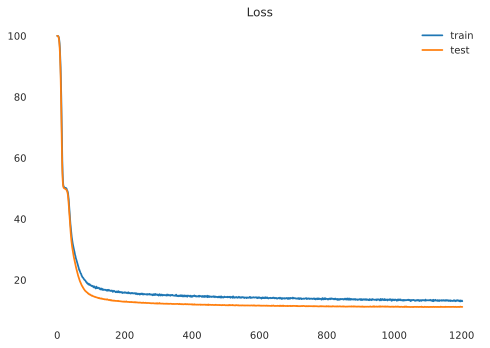

In [92]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.legend()
plt.show();

In [93]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_1.hdf5')

In [94]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

TEST mape: 11.16%


TEST mape: 11.16% при | epochs=500  
TEST mape: 11.32%  при | sigmoid вместо relu на первом слое | epochs=2500 - остановился на 260 эп | earlystop (patience=100) | optimizer = tf.keras.optimizers.Adam(0.01)  
TEST mape: 11.10% при | sigmoid вместо relu на первом слое | epochs=2500 - остновился на 1232 эп | earlystop (patience=100) | optimizer = tf.keras.optimizers.Adam(0.001)  

In [96]:
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = sub_predict_nn1[:,0]
sample_submission.to_csv('nn1_submission.csv', index=False)

# Model 4: NLP + Multiple Inputs

In [97]:
data.description.sample(4)

423     3й владелец. Пробег родной. Покупал в major ex...
1079    В отличном состоянии. Сел и поехал. Двигатель ...
4964    Один владелец,  ТО-А  пройдено.\n\nМашина полн...
1509    Машина в хорошем состоянии, ездила девушка. В ...
Name: description, dtype: object

In [99]:
import nltk
nltk.download("stopwords")

from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [101]:
morph = pymorphy2.MorphAnalyzer()
data_NLP = data.copy()

In [193]:
#создадим функцию. в которой будет и лемматизация и очистка текста

patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+●•✅☑️☛✔▼。№«»➥®₽●"
russian_stopwords = stopwords.words("russian")
additional_words = 'ваш 000 весь есть км 3 я наш 9 5 м это каждый 4 нет день с 7 мой m benz время' \
                   '00 10 8 тыс возможный й д г рубль из деньги внимание года рука мочь просьба' \
                   'также который любой м очень час возможный сделать звонить 00 мочь л in в и с' \
                   'на не по все для от до при у без за то из есть вы так это я как т руб'.split()

def lemmatize(doc):
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        token = token.strip()
        token = morph.normal_forms(token)[0]
        tokens.append(token)
    tokens = [token for token in tokens if token not in russian_stopwords]
    tokens = [token for token in tokens if token not in additional_words]
    return ' '.join(tokens)

In [103]:
data_NLP['description'] = data_NLP['description'].apply(lemmatize)

In [104]:
data_NLP['description'].sample(5)

2053    отличный состояние купить 2017г. новый летний ...
6756    авто отличный состояние, второй владелец, бере...
5053    машина идеальный состояние !без какой-либо про...
2238    автомобиль купить новый 2018 год автосалон мер...
967     владеть авто май 2019 немецкий сборка ноябрь 2...
Name: description, dtype: object

In [105]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [106]:
# split данных
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

### Tokenizer

In [107]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n•–∙—″°“☑️✔▼。 №«»➥®₽●·✅☛———————————————————————————')
tokenize.fit_on_texts(data.description)

CPU times: user 1.32 s, sys: 9.68 ms, total: 1.33 s
Wall time: 1.33 s


In [108]:
tokenize.word_index

{'в': 1,
 'и': 2,
 'с': 3,
 'на': 4,
 'не': 5,
 'по': 6,
 'система': 7,
 'автомобиль': 8,
 'все': 9,
 'для': 10,
 'автомобиля': 11,
 'от': 12,
 'до': 13,
 'при': 14,
 'пробегом': 15,
 'у': 16,
 '2': 17,
 'состоянии': 18,
 'без': 19,
 'авто': 20,
 'салон': 21,
 'пакет': 22,
 'за': 23,
 'машина': 24,
 'автомобилей': 25,
 'сидений': 26,
 'птс': 27,
 'безопасности': 28,
 'то': 29,
 'bmw': 30,
 'из': 31,
 'более': 32,
 '000': 33,
 'автомобили': 34,
 'водителя': 35,
 'комплектация': 36,
 'есть': 37,
 '1': 38,
 'сиденья': 39,
 'года': 40,
 'комплект': 41,
 'только': 42,
 'дилера': 43,
 'салона': 44,
 'пробег': 45,
 'контроль': 46,
 'фары': 47,
 'кредит': 48,
 '6': 49,
 'диски': 50,
 'лет': 51,
 'передние': 52,
 '3': 53,
 'руля': 54,
 'датчик': 55,
 'пассажира': 56,
 'км': 57,
 'оригинал': 58,
 'подушки': 59,
 'а': 60,
 'мы': 61,
 'подогрев': 62,
 '9': 63,
 'заднего': 64,
 'состояние': 65,
 'обогрев': 66,
 'вас': 67,
 '5': 68,
 'обслуживание': 69,
 'зеркал': 70,
 'торг': 71,
 'дтп': 72,
 'м': 

In [109]:
%%time
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

(5679, 256) (1003, 256) (1671, 256)
CPU times: user 1.45 s, sys: 2.7 ms, total: 1.45 s
Wall time: 1.45 s


In [110]:
# вот так теперь выглядит наш текст
print(text_train.iloc[6])
print(text_train_sequences[6])

.

• Автомобиль проверен по 110 пунктам
• Автокредит по специальной ставке от 13,7%

Ауди Центр Север, официальный дилер Audi, входящий в группу компаний РОЛЬФ и являющийся одним из крупнейших дилеров в Европе, предлагает Вам ряд услуг по покупке и продаже автомобилей с пробегом.

На протяжении многих лет наш дилерский центр является лидером по продаже автомобилей с пробегом среди всех дилеров Audi в России и предоставляет клиентам самый большой выбор автомобилей с пробегом Audi и других марок.
Каждый автомобиль проходит тщательную диагностику и подготовку, и гарантировано находится в отличном состоянии.
Чтобы убедиться в правильном выборе, у Вас есть возможность пройти тест-драйв ― ознакомительную поездку на интересующем автомобиле.
Вы сможете ознакомиться с автомобилем не выходя из дома – наш менеджер проведет online презентацию и в видеозвонке покажет выбранный автомобиль.
Также Ауди Центр Север представляет уникальное предложение по кредитованию автомобилей с пробегом на индивидуал

### RNN NLP

In [111]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.Dense(64, activation="sigmoid"))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

### MLP

In [112]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="sigmoid"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

### Multiple Inputs NN

In [113]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [114]:
# model.summary()

### Fit

In [115]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [116]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=20, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [117]:
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=500, # обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - 5s 420ms/step - loss: 99.6678 - MAPE: 99.6678 - val_loss: 96.4671 - val_MAPE: 96.4671
Epoch 2/500
12/12 [==============================] - 4s 353ms/step - loss: 76.9075 - MAPE: 76.9075 - val_loss: 56.5164 - val_MAPE: 56.5164
Epoch 3/500
12/12 [==============================] - 5s 378ms/step - loss: 53.9283 - MAPE: 53.9283 - val_loss: 52.2093 - val_MAPE: 52.2093
Epoch 4/500
12/12 [==============================] - 4s 344ms/step - loss: 49.5445 - MAPE: 49.5445 - val_loss: 46.6309 - val_MAPE: 46.6309
Epoch 5/500
12/12 [==============================] - 4s 347ms/step - loss: 44.3054 - MAPE: 44.3054 - val_loss: 37.9582 - val_MAPE: 37.9582
Epoch 6/500
12/12 [==============================] - 4s 350ms/step - loss: 35.9132 - MAPE: 35.9132 - val_loss: 30.3624 - val_MAPE: 30.3624
Epoch 7/500
12/12 [==============================] - 4s 367ms/step - loss: 30.4551 - MAPE: 30.4551 - val_loss: 25.6451 - val_MAPE: 25.6451
Epoch 8/500
12/12 [========

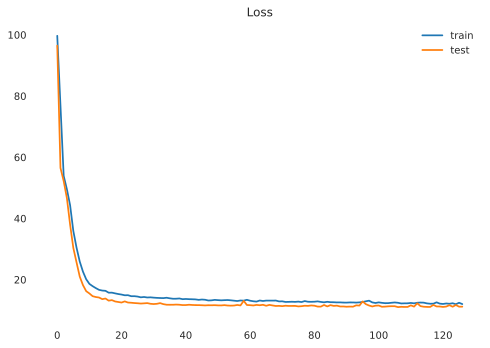

In [118]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.legend()
plt.show();

In [119]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_mlp_nlp.hdf5')

In [120]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

TEST mape: 11.18%


Пробовал несколько разных архитектур NLP и MLP моделей. Эксперементировал с параметрами patience callback фукнции earlystop.  
Ниже некоторые из них:  
TEST mape: 11.76% при |  autostop на 120 эпохе | patience=10 | optimizer - Adam(0.01)  
TEST mape: 11.60% при | autostop на 500 эпохе | patience=20 | optimizer - Adam(0.001) + RNN NLP (Dense(64, activation="sigmoid")) + MLP (Dense(256, activation="relu")  
TEST mape: 11.35%  при | autostop на 212 эпохе | patience=50 | optimizer  - Adam(0.01) + RNN NLP (Dense(64, activation="sigmoid")) + MLP (Dense(256, activation="relu")

In [121]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn2[:,0]
sample_submission.to_csv('nn2_submission.csv', index=False)  # score= 11.73881 on leaderboard

Идеи для улучшения NLP части:
* Выделить из описаний часто встречающиеся блоки текста, заменив их на кодовые слова или удалив
* Сделать более тщательно предобработку текста, например, сделать лемматизацию - алгоритм ставящий все слова в форму по умолчанию (глаголы в инфинитив и т. д.), чтобы токенайзер не преобразовывал разные формы слова в разные числа
Статья по теме: https://habr.com/ru/company/Voximplant/blog/446738/
* Поработать над алгоритмами очистки и аугментации текста

# Model 5: Добавляем картинки

### Data

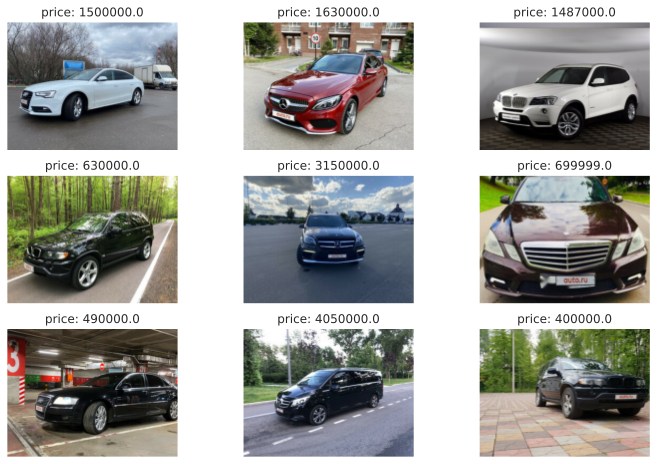

In [125]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [126]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5679, 240, 320, 3) dtype uint8
images shape (1003, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


### albumentations

In [127]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)

In [128]:
AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=30, interpolation=1, border_mode=4,
                          value=None, mask_value=None, always_apply=False, p=0.5),
    albumentations.OneOf([
        albumentations.CenterCrop(height=224, width=200),
        albumentations.CenterCrop(height=200, width=224),
    ], p=0.5),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(
            brightness_limit=0.3, contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(
            brightness_limit=0.1, contrast_limit=0.1)
    ], p=0.5),
    albumentations.GaussianBlur(p=0.05),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.RGBShift(p=0.5),
    albumentations.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
    albumentations.Resize(240, 320)
])

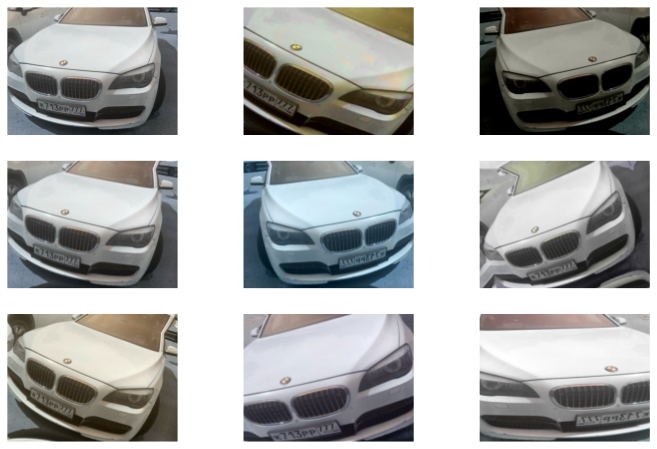

In [129]:
#пример
plt.figure(figsize = (12,8))
for i in range(9):
    img = AUGMENTATIONS(image = images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [130]:
def make_augmentations(images):
  print('применение аугментаций', end = '')
  augmented_images = np.empty(images.shape)
  for i in range(images.shape[0]):
    if i % 200 == 0:
      print('.', end = '')
    augment_dict = AUGMENTATIONS(image = images[i])
    augmented_image = augment_dict['image']
    augmented_images[i] = augmented_image
  print('')
  return augmented_images

In [131]:
# NLP part
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data_NLP['description'])

In [132]:
def process_image(image):
    return AUGMENTATIONS(image=image.numpy())['image']

def tokenize_(descriptions):
  return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]


def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image, ] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text, ] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price


def tf_process_val_dataset_element(image, table_data, text, price):
    [text, ] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price


train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data.description.iloc[X_train.index], y_train
)).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data.description.iloc[X_test.index], y_test
)).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data.description.iloc[X_sub.index], y_sub
)).map(tf_process_val_dataset_element)

# проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__()
test_dataset.__iter__().__next__()
sub_dataset.__iter__().__next__()

((<tf.Tensor: shape=(240, 320, 3), dtype=uint8, numpy=
  array([[[130, 123, 120],
          [128, 121, 118],
          [170, 163, 160],
          ...,
          [147, 152, 153],
          [219, 228, 231],
          [201, 212, 216]],
  
         [[186, 179, 176],
          [229, 222, 219],
          [210, 203, 200],
          ...,
          [152, 157, 158],
          [220, 229, 232],
          [200, 211, 215]],
  
         [[175, 168, 165],
          [224, 217, 214],
          [214, 207, 204],
          ...,
          [157, 162, 165],
          [221, 230, 233],
          [200, 211, 215]],
  
         ...,
  
         [[127, 118, 105],
          [118, 109,  96],
          [130, 121, 108],
          ...,
          [133, 121, 115],
          [145, 132, 124],
          [174, 162, 152]],
  
         [[124, 113,  99],
          [131, 119, 107],
          [123, 111,  99],
          ...,
          [156, 147, 138],
          [153, 143, 133],
          [163, 153, 143]],
  
         [[133, 122, 10

### Строим сверточную сеть для анализа изображений без "головы"

In [133]:
#нормализация включена в состав модели EfficientNetB3, поэтому на вход она принимает данные типа uint8
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB3(weights='imagenet', include_top=False, input_shape=(size[1], size[0], 3))

43941888/43941136 [==============================] - 5s 0us/step


In [135]:
# Для начала, сеть, которую подгрузили,никак не обучаем. Будем обучать только верхние слои,которые мы рандомно инициализировали
efficientnet_model.trainable = True

# Будем работать со слоями начиная с этого момента
fine_tune_at = len(efficientnet_model.layers)//2

# Keep all other layers frozen
for layer in efficientnet_model.layers[:fine_tune_at]:
    layer.trainable =  False
    
# проверим количество и статус слоев
print(len(efficientnet_model.layers))

for layer in efficientnet_model.layers:
    print(layer, layer.trainable)

In [137]:
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

In [138]:
# нейросеть для анализа табличных данных
tabular_model = Sequential([
    L.Input(shape = X.shape[1]),
    L.Dense(512, activation = 'sigmoid'),
    L.LayerNormalization(),
    L.Dropout(0.5),
    L.Dense(256, activation = 'relu'),
    L.Dense(256, activation = 'relu'),
    L.Dropout(0.5),
    ])

In [139]:
# NLP
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LayerNormalization(),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.Dense(128, activation = 'sigmoid'),
    L.Dropout(0.5),
    L.LSTM(64),
    L.Dropout(0.25),
    L.Dense(64),
    L.Dropout(0.25)
    ])

In [140]:
# объединяем выходы трех нейросетей
combinedInput = L.concatenate(
    [efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input,
                      tabular_model.input, nlp_model.input], outputs=head)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 240, 320, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 240, 320, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 321, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [141]:
optimizer = tf.keras.optimizers.Adam(0.005)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [142]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [143]:
%%time
history = model.fit(train_dataset.batch(30),
                    epochs=100,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                   )

Epoch 1/100
190/190 [==============================] - 64s 337ms/step - loss: 39.8179 - MAPE: 39.8179 - val_loss: 64.9902 - val_MAPE: 64.9902
Epoch 2/100
190/190 [==============================] - 61s 319ms/step - loss: 19.4359 - MAPE: 19.4359 - val_loss: 14.6885 - val_MAPE: 14.6885
Epoch 3/100
190/190 [==============================] - 60s 316ms/step - loss: 17.8544 - MAPE: 17.8544 - val_loss: 13.8535 - val_MAPE: 13.8535
Epoch 4/100
190/190 [==============================] - 58s 306ms/step - loss: 16.7830 - MAPE: 16.7830 - val_loss: 13.6200 - val_MAPE: 13.6200
Epoch 5/100
190/190 [==============================] - 58s 304ms/step - loss: 16.7271 - MAPE: 16.7271 - val_loss: 15.1819 - val_MAPE: 15.1819
Epoch 6/100
190/190 [==============================] - 58s 303ms/step - loss: 15.7799 - MAPE: 15.7799 - val_loss: 12.4084 - val_MAPE: 12.4084
Epoch 7/100
190/190 [==============================] - 58s 307ms/step - loss: 15.7530 - MAPE: 15.7530 - val_loss: 12.5385 - val_MAPE: 12.5385
Epoch 

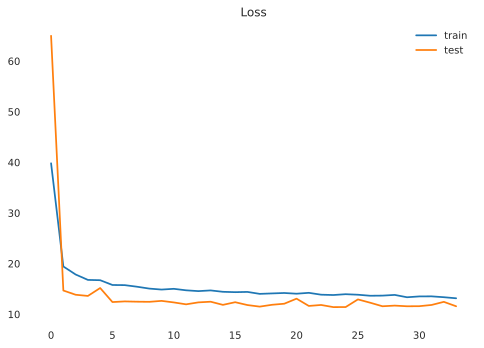

In [145]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.legend()
plt.show();

In [146]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_final.hdf5')

In [147]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

TEST mape: 11.58%


In [148]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))
sample_submission['price'] = sub_predict_nn3[:,0]
sample_submission.to_csv('nn3_submission.csv', index=False)

# Blend

### Blend - Score: 11.37609

In [152]:
blend_predict_2 = (test_predict_catboost + test_predict_nn1[:,0]+ test_predict_nn2[:,0]+ test_predict_nn3[:,0]) / 4
print(f"TEST mape: {(mape(y_test, blend_predict_2))*100:0.2f}%")

TEST mape: 10.76%


In [153]:
blend_sub_predict_2 = (sub_predict_catboost + sub_predict_nn1[:,0] + sub_predict_nn2[:,0] + sub_predict_nn3[:,0]) / 4
sample_submission['price'] = blend_sub_predict_2
sample_submission.to_csv('blend_2_submission.csv', index=False)

# Проброс признака

In [176]:
# MLP
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

In [177]:
# FEATURE Input
# Iput
log_carage = L.Input(shape=[1], name="log_car_age")
# Embeddings layers
emb_log_carage = L.Embedding(len(np.exp(data.log_car_age).unique().tolist())+1, 20)(log_carage)
f_log_carage = L.Flatten()(emb_log_carage)

In [178]:
combinedInput = L.concatenate([model_mlp.output, f_log_carage,])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_mlp.input, log_carage], outputs=head)

In [179]:
model.summary()

Model: "functional_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_30_input (InputLayer)     [(None, 233)]        0                                            
__________________________________________________________________________________________________
dense_30 (Dense)                (None, 512)          119808      dense_30_input[0][0]             
__________________________________________________________________________________________________
dropout_17 (Dropout)            (None, 512)          0           dense_30[0][0]                   
__________________________________________________________________________________________________
log_car_age (InputLayer)        [(None, 1)]          0                                            
______________________________________________________________________________________

In [180]:
optimizer = tf.keras.optimizers.Adam(0.01)
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [181]:
history = model.fit([X_train, np.exp(X_train.log_car_age).values], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([X_test, np.exp(X_test.log_car_age).values], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - 0s 23ms/step - loss: 99.9936 - MAPE: 99.9936 - val_loss: 99.9153 - val_MAPE: 99.9153
Epoch 2/500
12/12 [==============================] - 0s 7ms/step - loss: 99.1003 - MAPE: 99.1003 - val_loss: 95.6379 - val_MAPE: 95.6379
Epoch 3/500
12/12 [==============================] - 0s 7ms/step - loss: 84.8296 - MAPE: 84.8296 - val_loss: 59.8671 - val_MAPE: 59.8671
Epoch 4/500
12/12 [==============================] - 0s 7ms/step - loss: 57.1057 - MAPE: 57.1057 - val_loss: 53.1136 - val_MAPE: 53.1136
Epoch 5/500
12/12 [==============================] - 0s 7ms/step - loss: 50.1903 - MAPE: 50.1903 - val_loss: 46.6649 - val_MAPE: 46.6649
Epoch 6/500
12/12 [==============================] - 0s 7ms/step - loss: 43.8018 - MAPE: 43.8018 - val_loss: 39.8113 - val_MAPE: 39.8113
Epoch 7/500
12/12 [==============================] - 0s 7ms/step - loss: 38.2572 - MAPE: 38.2572 - val_loss: 34.5639 - val_MAPE: 34.5639
Epoch 8/500
12/12 [=====================

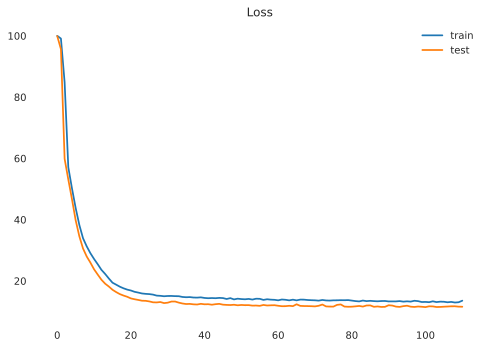

In [182]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.legend()
plt.show();

In [184]:
model.load_weights('../working/best_model.hdf5')
test_predict_nn_bonus = model.predict([X_test, np.exp(X_test.log_car_age).values])
print(f"TEST mape: {(mape(y_test, test_predict_nn_bonus[:,0]))*100:0.2f}%")

TEST mape: 11.58%


In [185]:
sub_predict_nn4 = model.predict([X_sub, np.exp(X_sub.log_car_age).values])
sample_submission['price'] = sub_predict_nn4[:,0]
sample_submission.to_csv('nn4_submission.csv', index=False)

### Blend with nn4 - score 11.36165 on leaderboard

In [188]:
blend_sub_predict_3_new = (sub_predict_catboost + sub_predict_nn1[:,0] + sub_predict_nn2[:,0] + sub_predict_nn3[:,0] + sub_predict_nn4[:,0]) / 5
sample_submission['price'] = blend_sub_predict_3_new
sample_submission.to_csv('blend_3_new_submission.csv', index=False)

Прием "проброс признака" позволил добавить при блендинге 0.015 к score на лидерборде, а именно 11.36165 вместо 11.37609.

## Округление предсказанния  
Метрика не улучшилась. Score 11.36165 на лидерборде.

In [192]:
blend_sub_predict_3_new = (sub_predict_catboost + sub_predict_nn1[:,0] + sub_predict_nn2[:,0] + sub_predict_nn3[:,0] + sub_predict_nn4[:,0]) / 5
sample_submission['price'] = np.round(blend_sub_predict_3_new)
sample_submission.to_csv('blend_4_submission.csv', index=False)

### Выводы по проекту  
В рамках проекта выполнена предобработка данных. Разведывательный анализ дал понимание с какими данными мы работаем, а так же выводы по удалению некоторыз признаков, которые либо имели большое кол-во пропусков данных, либо только 1 значение, или высокую корреляцию между собой. Созданы новые признаки. В рамках обработки языка были применены токенизация и лематизация данных. Однако, считаю, что текстовые данные можно было обработать лучше. Ограниченность по времени не позволила это сделать. При работе с изображениями использовалась библиотека albumentation, которая позволяет создать больше данных в условиях их нехватки.
В рамках проекта удалось попрактиковаться с multi-input моделями, аркестрацию моделей и проброс признака. На практике оценил значимость такого приема как блендинг предсказаний, который позволил получить score 11.36165 на лидерборде.